In [28]:
import os
from glob import glob
from subprocess import check_call
import yaml

import xarray as xr

import util

In [16]:
data_campaign = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6'

with open('cplhist-cases.yml') as fid:
    cplhist_cases = yaml.safe_load(fid)

In [10]:
cplhist_case_list = [d['case'] for e, d in cplhist_cases.items()]
cplhist_case_list

['b.e21.BHIST.f09_g17.CMIP6-historical.011']

In [36]:
def ncrcat_surface_salinity(file_list, file_out):
    """Concatenate SALT files and subset z_t=0"""

    # concatenate files
    ncrcat_cmd = " ".join([
        "ncrcat", "-O", 
        "-d z_t,0", 
        "-v SALT,TLAT,TLONG,time,time_bound",
        "-o", file_out, 
        ' '.join(file_list)])    
    check_call(" && ".join(["module load nco", ncrcat_cmd]), shell=True)

    # change file format
    ncks_cmd = " ".join(["ncks", "-O", "--fl_fmt=64bit_offset", file_out, file_out])
    check_call(" && ".join(["module load nco", ncks_cmd]), shell=True)    

    # remove z_t dimension
    ncwa_cmd = " ".join(["ncwa", "-a", "z_t", "-O", file_out, file_out])
    check_call(" && ".join(["module load nco",

In [142]:
%%time
freq = 'day_1'

clobber = False

assert freq in ['month_1', 'day_1']

varname = 'SALT' if freq == 'month_1' else 'SSS'
freq_str = 'monthly' if freq == 'month_1' else 'daily'
isel_z = {'z_t': 0} if freq == 'month_1' else {}

for case in cplhist_case_list:
    
    dirout = f"{util.restoring_data_stage_root}/{case}"
    os.makedirs(dirout, exist_ok=True)    
    
    files = sorted(glob(f"{data_campaign}/{case}/ocn/proc/tseries/{freq}/*.{varname}.*.nc"))

    datestr0 = files[0].split('.')[-2]
    datestr1 = files[-1].split('.')[-2]      
    datestr_out = '-'.join([datestr0.split('-')[0], datestr1.split('-')[1]])    
    
    file_out = f"{dirout}/{case}.SSS.{freq[:3]}.{datestr_out}.ieeer8"   

    if not os.path.exists(file_out) or clobber:
        ds = xr.open_mfdataset(
            files, 
            decode_cf=False, 
            decode_times=False, 
            decode_coords=False, 
            compat='override',
            coords='minimal',
            chunks={'time': 1},
        )
        with open(file_out, "wb") as fid: # or choose 'w+' mode - read "open()" documentation
            for i in range(ds.sizes['time']):
                array = ds[varname].isel(time=i, **isel_z).values.astype('>f8')
                array.tofile(fid)        
        

CPU times: user 59min 26s, sys: 2min 53s, total: 1h 2min 20s
Wall time: 1h 4min 27s


In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [124]:
nlat, nlon = 384, 320

sfwf_filename = '/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/sfwf_mm_WOA13v2_salx_flxio_gx1v7_20170706.ieeer8'
data = np.fromfile(sfwf_filename, dtype='>f8', count=-1)
data = data.reshape((24, nlat, nlon))
data = np.where(data < 0, np.nan, data)

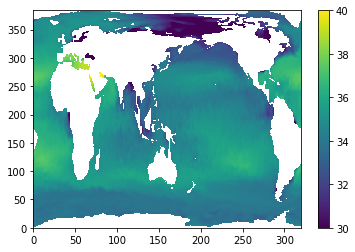

In [125]:
pc = plt.pcolormesh(data[0, :, :], vmin=30, vmax=40)
plt.colorbar(pc)


In [126]:
file_out

'/glade/scratch/mclong/cplhist_data/restoring_data/b.e21.BHIST.f09_g17.CMIP6-historical.011/b.e21.BHIST.f09_g17.CMIP6-historical.011.pop.h.SALT.185001-201412.ieeer8'

In [132]:
data = np.fromfile(file_out, dtype='>f8', count=nlat*nlon)
data = data.reshape((nlat, nlon))
data = np.where(data > 1e33, np.nan, data)

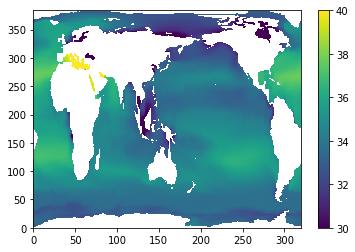

In [135]:
pc = plt.pcolormesh(data[:, :] * 1000.0, vmin=30, vmax=40)
plt.colorbar(pc)


In [118]:
import numpy as np

alist=[]
c = 1

file_bin = f"{dirout}/binary.ieeer8"

with open(file_bin, "wb") as fid: # or choose 'w+' mode - read "open()" documentation
    for i in range(ds.sizes['time']):
        array = ds.SALT.isel(time=i).values.astype('>f8')
        array.tofile(fid)


In [119]:
data = np.fromfile(file_bin, count=nlat*nlon, dtype='>f8')
data = data.reshape((nlat, nlon))
data = np.where(data > 1e33, np.nan, data)

data

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [32.88994598, 32.88661194, 32.88507843, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

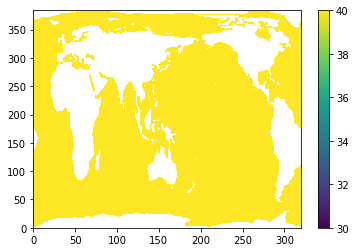

In [115]:
pc = plt.pcolormesh(data[:, :]*1000.0, vmin=30, vmax=40)
plt.colorbar(pc)

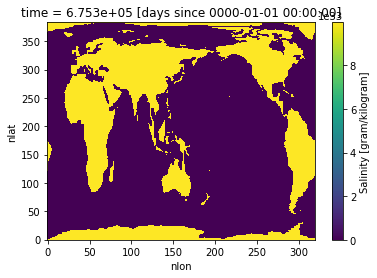

In [111]:
ds.SALT.isel(time=0).plot()